# Coding CNNs from Scratch with Pytorch

In this assignment you will code a famous CNN architecture AlexNet (https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) to classify images from the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 10 classes of natural images such as vehicles or animals. AlexNet is a landmark architecture because it was one of the first extremely deep CNNs trained on GPUs, and achieved state-of-the-art performance in the ImageNet challenge in 2012. 


A lot of code will already be written to familiarize yourself with PyTorch, but you will have to fill in parts that will apply your knowledge of CNNs. Additionally, there are some numbered questions that you must answer either in a separate document, or in this notebook. Some questions may require you to do a little research. To type in the notebook, you can insert a text cell. 

Let's start by installing PyTorch and the torchvision package below. Due to the size of the network, you will have to run on a GPU. So, click on the Runtime dropdown, then Change Runtime Type, then GPU for the hardware accelerator. 

In [1]:
!pip install pytorch
!pip install torchvision
!pip install numpy
!pip install torchsummary
!pip install torch torchvision
!pip install matplotlib

  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ahs9hjp4/pytorch_16fa6515a90e4fcdad1c72ff86b25cdc/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ahs9hjp4/pytorch_16fa6515a90e4fcdad1c72ff86b25cdc/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-7lj6h8bq/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pytorch Check the logs for full command output.


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


device = torch.device('cuda')
    
print(device)


cuda


### 1. In the following cell, we are employing something called "data augmentation" with random horizontal and vertical flips. So when training data is fed into the network, it is ranadomly transformed. What are advantages of this?
It allows learning the same image from different dimensions allowing the algorithm to be more robust in learning the features. It also increases the input sample size which can help reduce variance since it lets the model be more general.

### 2. We normalize with the line transforms.Normalize((0.5,), (0.5,)). What are the benefits of normalizing data? 
Features across different input examples wil have a large variance due to the underlying systems that generate them. This can skew the learning, hence we normalise to make sure all the features are in the same range. This transforms our data distribution to a sphere, centred at the mean.



In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from math import ceil

BATCH_SIZE = 100


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5), 
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

torch.manual_seed(43)
val_size = 10000
train_size = len(trainset) - val_size


train_ds, val_ds = random_split(trainset, [train_size, val_size])
print(len(train_ds), len(val_ds))


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_steps =  ceil(len(train_ds) / BATCH_SIZE)
num_steps

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
40000 10000


400

In [4]:
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testset, BATCH_SIZE)

You can insert an integer  into the code trainset[#insert integer] to visualize images from the training set. Some of the images might look weird because they have been randomly flipped according to our data augmentation scheme. 

Label (numeric): 9
Label (textual): truck


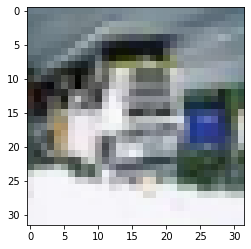

In [5]:
img, label = trainset[1000]
plt.imshow((img.permute((1, 2, 0))+1)/2)
print('Label (numeric):', label)
print('Label (textual):', classes[label])

Now comes the fun part. You will have to put in the correct parameters into different torch.nn functions in order to convolve and downsample the image into the correct dimensionality for classification. Think of it as a puzzle. You will insert the parameters where there is a comment #TODO. 

In [6]:
print(img.size())

torch.Size([3, 32, 32])


In [7]:
# in_channels : Number of inputs
# out_channels : number of kernels basically
# FIXME :: Where do we input input size??
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 3,
                      out_channels = 64,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, 
                      padding=1), #FIXME
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 
                      384,
                      kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
            
        #Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(1024, 4096), # check the input size
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10), #FIXME
        )

    def forward(self, x):
        x = self.features(x)
        #we must flatten our feature maps before feeding into fully connected layers
        x = x.contiguous().view(x.size(0), 1024) # 32*32
        x = self.classifier(x)
        return x

Below we are initializing our model with a weight scheme.

In [8]:
net = Discriminator()

def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
net = net.to(device)

net.apply(weights_init)



Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0

### 3. Notice above in our network architecture, we have what are called "Dropout" layers. What is the point of these?

They are meant for regularisation to avoid overfitting.

Defining our cost/loss function, which is cross-entropy loss. We also define our optimizer with hyperparameters: learning rate and betas. 

In [10]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=0.0001,
    betas = (0.5, 0.999)
)



Below we actually train our network. Run for just 10 epochs. It takes some time. Wherever there is the comment #TODO, you must insert code.

In [11]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
              ReLU-2           [-1, 64, 16, 16]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         110,784
              ReLU-5            [-1, 192, 8, 8]               0
         MaxPool2d-6            [-1, 192, 4, 4]               0
            Conv2d-7            [-1, 384, 4, 4]         663,936
              ReLU-8            [-1, 384, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         884,992
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         590,080
             ReLU-12            [-1, 256, 4, 4]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
          Dropout-14                 [-

In [12]:
train_loss = []
valid_loss = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)     #pass input data into network to get outputs
        loss = criterion(outputs, labels)
        loss.backward()  #calculate gradients
        optimizer.step() #take gradient descent step

           
        running_loss += loss.item()
        
        
            
    
    print("E:{}, Train Loss:{}".format(
                epoch+1,
                running_loss / num_steps
            )
        )
    train_loss.append(running_loss / num_steps)
    
                
    #validation
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            #TODO: load images and labels from validation loader
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images) #TODO  #run forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                
            loss = criterion(outputs, labels)       #calculate validation loss
            val_loss += loss.item()
    val_loss /=num_steps
    print('Accuracy of 10000 val images: {}'.format( correct / total))
    print('Val Loss: {}'.format( val_loss))
    valid_loss.append(val_loss)
print('Finished Training')


E:1, Train Loss:1.959847365617752
Accuracy of 10000 val images: 0.311
Val Loss: 0.44030613273382185
E:2, Train Loss:1.6758774974942208
Accuracy of 10000 val images: 0.3811
Val Loss: 0.40872260570526125
E:3, Train Loss:1.5257530051469803
Accuracy of 10000 val images: 0.4554
Val Loss: 0.3672903999686241
E:4, Train Loss:1.4228433188796044
Accuracy of 10000 val images: 0.4704
Val Loss: 0.36005661100149156
E:5, Train Loss:1.3332081925868988
Accuracy of 10000 val images: 0.5118
Val Loss: 0.328680998980999
E:6, Train Loss:1.267854163646698
Accuracy of 10000 val images: 0.5165
Val Loss: 0.3306643870472908
E:7, Train Loss:1.2022551642358303
Accuracy of 10000 val images: 0.5518
Val Loss: 0.3023109436035156
E:8, Train Loss:1.1472478939592838
Accuracy of 10000 val images: 0.5687
Val Loss: 0.2950465168058872
E:9, Train Loss:1.1005234199762344
Accuracy of 10000 val images: 0.5807
Val Loss: 0.2895585677027702
E:10, Train Loss:1.059796066135168
Accuracy of 10000 val images: 0.5923
Val Loss: 0.28261411

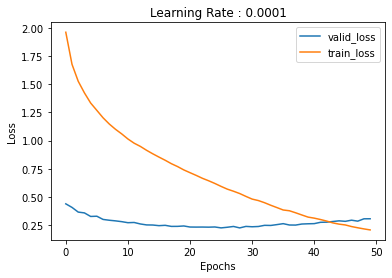

In [13]:
plt.plot(valid_loss)
plt.plot(train_loss)
plt.legend(['valid_loss', 'train_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Rate : 0.0001')
plt.show()

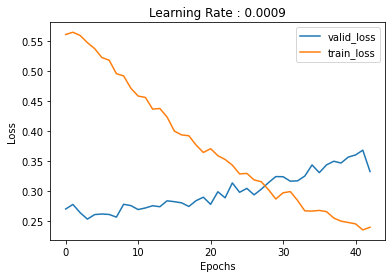

In [ ]:
plt.plot(valid_loss)
plt.plot(train_loss)
plt.legend(['valid_loss', 'train_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Rate : 0.0009')
plt.show()

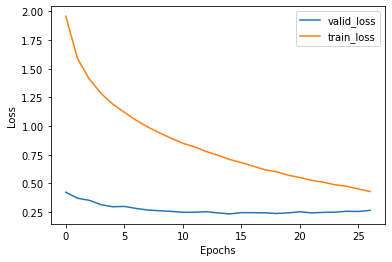

In [ ]:
plt.plot(valid_loss)
plt.plot(train_loss)
plt.legend(['valid_loss', 'train_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## 4. If we train for more epochs, our accuracy/performance will increase. What happens if we train for too long though? What method can be employed to mitigate this?

We can cause overfitting if we train for too long. To mitigate this issue we should monitor the training and validation error. The point at which validation error starts increasing should mark our end of training.

## 5. Try increasing learning rate and look at the metrics for training and validation data? What do you notice? Why do think this is happening?
Increasing the learning rate causes more oscillations in the loss curve. Comparing the plots with learning rate(lr) 0.0009 and 0.0001 it is evident. Also, the validation error starts increasing around 25th epoch for 0.0009 trend as opposed to ~40 epochs with lr as 0.0001. This is due to teh fact that with a larger lr the loss decreses at ahigher rate to it nears the minima faster. However, with a larger lr the cost-function is unable to reach the absolute minima instead is bouncing back and forth hence the zagged trend.


We can see the performance on the testing set now. 

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of 10000 test images: {}'.format( correct / total))

Accuracy of 10000 test images: 0.7022
